In [1]:
import os
import re
import time
import shutil
import math
import datetime

# 文件类型
import xml
import sqlite3

# 数据处理
import numpy as np
import pandas as pd
import scipy

# 绘图
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import math
import torch.nn as nn
from torch.nn import init

import numpy as np
# os.chdir(r'F:\学术\试验数据 - 副本\实验数据\30_60_90')
os.chdir(r'C:\Users\11655\Desktop\CONV1D\代码\ECG')

In [2]:
import torch
# from torchsummary import summary
from torch.utils.data import random_split, DataLoader, TensorDataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
#对输入数据进行处理-划分数据集
def putind(wenjian,batch_tr,batch_te,time ,id_sj0 = None):
    ECG = pd.read_pickle('90s_f.pkl')
    a = (-time/3 + 3)*3900
    a = int(a)
    ECG['ECG'] = ECG['ECG'].apply(lambda x:x[a:])
    X1 = ECG['ECG']
    Y1 = ECG['label']
    X1 = np.array(list(X1))
    
    
    X1 = X1.reshape(X1.shape[0],3900,-1).swapaxes(-2,-1)

        
    X1_T = torch.Tensor(X1)    
    Y1_1 = np.array(list(Y1))
    Y1_T= torch.Tensor(Y1_1)
    
#     if id_sj0 is None:
#         id_sj = np.arange(X1_T.shape[0])
#         np.random.shuffle(id_sj)
#         id_sj2 = pd.Series(id_sj)
#         id_sj2.to_pickle("./indexs/{}_{}.pkl".format(id_sj[0],id_sj[1]))
#         print("重新生成数据划分",(time.strftime("%Y-%m-%d %H:%M:%S")))
#     else:
#         id_sj = np.array(pd.read_pickle("./indexs/{}_{}.pkl".format(id_sj0[0],id_sj0[1])))
#         print("读入数据划分")
#     test = int(X1_T.shape[0]*0.3)
#     train = X1_T.shape[0]-test

#     id_sj_train,id_sj_test = id_sj[:train],id_sj[train:]
#     print("数据长度",train,test,len(id_sj_train),len(id_sj_test))
    
    
#     train_data = TensorDataset(X1_T[id_sj_train],Y1_T[id_sj_train])
#     test_data = TensorDataset(X1_T[id_sj_test],Y1_T[id_sj_test])
    train_data = TensorDataset(torch.cat([X1_T[::3],X1_T[1::3]]),torch.cat([Y1_T[::3],Y1_T[1::3]]))
    test_data = TensorDataset(X1_T[2::3],Y1_T[2::3])
    

    train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_tr,
    shuffle=True,
    num_workers=2,
    pin_memory=True)

    test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_te,
    shuffle=False,
    num_workers=2,
    pin_memory=True)
    return train_loader,test_loader

In [4]:
#对象---模型结构，模型搭建
class My_c(nn.Module):
    #模型头部的共同部分
    def __init__(self):
        super().__init__()
        self.cov_unit1 = nn.Sequential(
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64,128,kernel_size=5,stride=2,padding = 0),
            nn.Dropout(0.5),#因为模型训练过拟合加的
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128,128,kernel_size=5,stride=2,padding = 0),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128,256,kernel_size=5,stride=2,padding = 0),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Conv1d(256,256,kernel_size=5,stride=2,padding = 0),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True))
    def forward(self,input_):
        return self.cov_unit1(input_).transpose(-2,-1)
    
class My_l(nn.Module):
#     模型尾部共同部分
    def __init__(self):
        super().__init__()
        self.fc_unit = nn.Sequential(
            nn.Linear(3072,128),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,1),
            nn.Sigmoid())
    def forward(self,input_):
        return self.fc_unit(input_)
    
class Lenet5_lstm90(nn.Module):
    def __init__(self):
        super(Lenet5_lstm90,self).__init__()
        self.cov_unit1 = nn.Sequential(
            nn.Conv1d(3,64,kernel_size=5,stride=2,padding = 0),
            nn.ReLU(inplace=True))
        self.cov_unit2 = My_c()
        self.s1 = nn.LSTM(input_size=256,hidden_size=256,batch_first=True)          #1664*2
        self.fc_unit = My_l()

    def forward(self,input_):
        size_0 = input_.shape[0]
        af = self.cov_unit1(input_)
        af = self.cov_unit2(af)
#         af,aw = self.at(af,af,af)             #   使用attention
        af, (h2, c2) = self.s1(af)
        af = af.contiguous().view(size_0 ,-1)
        af = self.fc_unit(af)
        return af


    
class Lenet5_lstm60(nn.Module):
    def __init__(self):
        super(Lenet5_lstm60,self).__init__()
        self.cov_unit1 = nn.Sequential(
            nn.Conv1d(2,64,kernel_size=5,stride=2,padding = 0),
            nn.ReLU(inplace=True))
        self.cov_unit2 = My_c()
        self.s1 = nn.LSTM(input_size=256,hidden_size=256,batch_first=True)          #1664*2
        self.fc_unit = My_l()

    def forward(self,input_):
        size_0 = input_.shape[0]
        af = self.cov_unit1(input_)
        af = self.cov_unit2(af)
#         af,aw = self.at(af,af,af)             #   使用attention
        af, (h2, c2) = self.s1(af)
        af = af.contiguous().view(size_0 ,-1)
        af = self.fc_unit(af)
        return af


class Lenet5_lstm30(nn.Module):
    def __init__(self):
        super(Lenet5_lstm30,self).__init__()
        self.cov_unit1 = nn.Sequential(
            nn.Conv1d(1,64,kernel_size=5,stride=2,padding = 0),
            nn.ReLU(inplace=True))
        self.cov_unit2 = My_c()
        self.s1 = nn.LSTM(input_size=256,hidden_size=256,batch_first=True)          #1664*2
        self.fc_unit = My_l()

    def forward(self,input_):
        size_0 = input_.shape[0]
        af = self.cov_unit1(input_)
        af = self.cov_unit2(af)
#         af,aw = self.at(af,af,af)             #   使用attention
        af, (h2, c2) = self.s1(af)
        af = af.contiguous().view(size_0 ,-1)
        af = self.fc_unit(af)
        return af
        
class Lenet5_cnn30(nn.Module):
    def __init__(self):
        super(Lenet5_cnn30,self).__init__()
        self.cov_unit1 = nn.Sequential(
            nn.Conv1d(1,64,kernel_size=5,stride=2,padding = 0),
            nn.ReLU(inplace=True))
        self.cov_unit2 = My_c()
#         self.s1 = nn.LSTM(input_size=256,hidden_size=256,batch_first=True)          #1664*2
        self.fc_unit = My_l()

    def forward(self,input_):
        size_0 = input_.shape[0]
        af = self.cov_unit1(input_)
        af = self.cov_unit2(af)
#         af,aw = self.at(af,af,af)             #   使用attention
#         af, (h2, c2) = self.s1(af)
        af = af.contiguous().view(size_0 ,-1)
        af = self.fc_unit(af)
        return af

In [5]:
# 停止函数
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, save_path=1, patience=10, verbose=False, delta=0.01):
        """
        Args:
            save_path : 模型保存文件夹
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.save_path = save_path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.loss_mean = 100
        self.best_te_ac = 0.7

    def __call__(self, val_loss,train_loss, epo, model,ta_ac,te_ac):
        now_ac = min(te_ac,ta_ac)
        if now_ac>self.best_te_ac:
            self.best_te_ac = now_ac
            ret_save = 1
        else:
            ret_save = 0
        if self.best_te_ac>0.7:
            if te_ac+self.delta<self.best_te_ac:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience},best_is:{self.best_te_ac}')
            else:
                self.counter = 0
        
        if self.counter>=self.patience:
            ret_save_all = 1
        else:
            ret_save_all = 0
        return ret_save,ret_save_all

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        path = os.path.join(self.save_path, 'best_network.pth')
        torch.save(model.state_dict(), path)	# 这里会存储迄今最优模型的参数
        self.val_loss_min = val_loss

In [6]:
# 模型训练，定义优化器损失函数等
def moxing(wenjian,path_save,epochs,train_loader,test_loader,net,opt,loss_func,dfhistory_old = None,wj_name = "记录"):
    #3.准确度和优化器
#学习率
    if dfhistory_old is None:
        dfhistory = pd.DataFrame(columns = ["epoch","train_loss",'train_acc','test_acc','test_loss',"lr"])
    else:
        dfhistory = dfhistory_old
    early_stopping = EarlyStopping()
#     dfhistory = pd.DataFrame(columns = ["epoch","train_loss",'train_acc','test_acc','test_loss'])
    EPOCH=epochs
    gx = 0
    epoch = 0
    while 1:
        epoch +=1
        if epoch>EPOCH:
            break
        a,b,c,a1 = [],[],[],[]
        for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
            net.train()
            b_x=b_x.to(device)
            b_y=b_y.to(device)
#             print(b_x.shape)
            opt.zero_grad() 
            output = net(b_x)               # cnn output
            loss = loss_func(output.squeeze(1), b_y)   # cross entropy loss
            loss.backward()                 # backpropagation, compute gradients
            opt.step()                # apply gradients
            a1.append(loss.detach().cpu().numpy())
            with torch.no_grad():
                net.eval()
                test_output = net(b_x).squeeze(1)
                loss = loss_func(test_output, b_y)
                pred_y = torch.round(test_output)
                accuracy = float((pred_y == b_y).sum()) / float(b_y.size(0))
                a.append(loss.detach().cpu().numpy())
                b.append(accuracy)


        #验证集 测试
        with torch.no_grad():
            net.eval()
            all_size,all_accuracy = 0, 0 
            for step, (b_x, b_y) in enumerate(test_loader):   # 分配 batch data, normalize x when iterate train_loader
                b_x=b_x.to(device)
                b_y=b_y.to(device)
                test_output = net(b_x).squeeze(1)
                pred_y = torch.round(test_output)
                loss_te = loss_func(test_output, b_y)
                all_size += float(b_y.size(0))
                all_accuracy += float((pred_y == b_y).sum())
                c.append(loss_te.detach().cpu().numpy())

            accuracy_test = all_accuracy/all_size

            avg_loss,avg_train,avg_test,loss_test = sum(a)/len(a),sum(b)/len(b),accuracy_test,sum(c)/len(c)
            avg_loss_t = sum(a1)/len(a1)
            lr_logging = opt.state_dict()['param_groups'][0]['lr']
            dfhistory = dfhistory.append({"epoch":epoch,"train_loss":avg_loss,
                                          'train_acc':avg_train,'test_acc':accuracy_test,
                                          'test_loss':loss_test,"lr":lr_logging},ignore_index=True)
            print('Epoch: ', epoch, '| train loss: %.4f' % avg_loss,
                  '| train_accuracy: %.2f' % avg_train, '| test accuracy: %.2f' % avg_test,
                 "| rl:%.5f" % lr_logging,"| loss_test:%.3f" % loss_test,"| train loss t:%.4f" % avg_loss_t)

        bcpd,zzpd = early_stopping(loss_test,avg_loss, epoch, net,avg_train,avg_test)
        if bcpd:
            torch.save(net, './{}/{}/{}/{}/最优/net_model_{}_{}.pkl'.format(wj_name,wenjian[0],net_name[0],wenjian[-5],avg_train,avg_test))
        if zzpd:
            break

    return net,dfhistory

In [7]:
# wenjian为输入数据路径，lr初始学习率，net神经网络类型，path_save储存最好模型路径
def xunlian(net_name,wenjian,batch_tr,batch_te,time,lr,path_save,epochs,net_old = None,dfhistory_old = None,wj_name = "记录"):

    if net_old is None:
        if net_name == 'cnn30':
            net = Lenet5_cnn30().to(device)
        elif net_name == 'lstm30':
            net = Lenet5_lstm30().to(device)
        elif net_name == 'cnn60':
            net = Lenet5_cnn60().to(device)
        elif net_name == 'lstm60':
            net = Lenet5_lstm60().to(device)
        elif net_name == 'cnn90':
            net = Lenet5_lstm90().to(device)
        elif net_name == 'lstm90':
            net = Lenet5_lstm90().to(device)
    else:
        net = net_old
    train_loader,test_loader = putind(wenjian,batch_tr,batch_te,time,id_sj0=None)
#     loss_func = torch.nn.MSELoss(reduction='mean') 
    loss_func = torch.nn.BCELoss(reduction='mean')
    lr = lr
#     opt = torch.optim.SGD(net.parameters(),lr=lr)
    opt = torch.optim.Adam(net.parameters(),
                    lr=lr,
                    betas=(0.9, 0.999),
                    eps=1e-08,
                    weight_decay=1e-5,
                    amsgrad=False)
    net,dfhistory = moxing(wenjian,path_save,epochs,train_loader,test_loader,net,opt,loss_func,dfhistory_old,wj_name)
#     cfjl_times = 0
#     if epochs>201:
#         while 1:
#             cfjl_times += 1
#             dfhistory_old = dfhistory.copy()
#             a = dfhistory_old["train_acc"][-10:].mean()
#             b = dfhistory_old ['train_acc'][-60:-50].mean()
#             if (a - b<=0.02 and a-b>=-0.005) or cfjl_times>5:
#                 break
#             net,dfhistory = moxing(wenjian,path_save,100,train_loader,test_loader,net,opt,loss_func,dfhistory_old)
    
#     net.state_dict(),
    torch.save(net.state_dict(), "./{}/{}/{}/{}/net_parameter.pkl".format(wj_name,wenjian[0],net_name[0],wenjian[-5]))        
    torch.save(net, './{}/{}/{}/{}/net_model.pkl'.format(wj_name,wenjian[0],net_name[0],wenjian[-5]))
    dfhistory.to_csv('./{}/{}/{}/{}/logging.csv'.format(wj_name,wenjian[0],net_name[0],wenjian[-5]))

In [8]:
# 图像平滑函数
def smooth(path):
    rolling_intv = 20
    df = pd.read_csv(path)
    train_loss = df['train_loss']
    test_loss = df['test_loss']
    train_acc = df['train_acc']
    test_acc = df['test_acc']
    train_loss1 = list(np.hstack(train_loss.rolling(rolling_intv, min_periods=1).mean().values))
    test_loss1 = list(np.hstack(test_loss.rolling(rolling_intv, min_periods=1).mean().values))
    train_acc1 = list(np.hstack(train_acc.rolling(rolling_intv, min_periods=1).mean().values))
    test_acc1 = list(np.hstack(test_acc.rolling(rolling_intv, min_periods=1).mean().values))
    xdata1 = list(range(len(train_loss1)))
    xdata2 = list(range(len(test_loss1)))
    xdata3 = list(range(len(train_acc1)))
    xdata4 = list(range(len(test_acc1)))
    plt.plot(xdata1,train_loss1)
    plt.plot(xdata2,test_loss1)
    plt.plot(xdata3,train_acc1)
    plt.plot(xdata4,test_acc1)
    plt.show()

In [13]:
shiyan_list = [
 ['30s_f.pkl', 'lstm30',3,3],
 ['60s_f.pkl', 'lstm60',1.5,6],
 ['90s_f.pkl', 'lstm90',1,9]]
for i in shiyan_list[::-1]:
    wenjian,net_name,bs,time = i
    print(time)

9
6
3


===============================  90s_f.pkl   =====   lstm90    ============================
Epoch:  1 | train loss: 0.6888 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.685 | train loss t:0.6887
Epoch:  2 | train loss: 0.6871 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6883
Epoch:  3 | train loss: 0.6841 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.683 | train loss t:0.6856
Epoch:  4 | train loss: 0.6616 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.649 | train loss t:0.6681
Epoch:  5 | train loss: 0.6179 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.597 | train loss t:0.6255
Epoch:  6 | train loss: 0.6011 | train_accuracy: 0.62 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.598 | train loss t:0.5999
Epoch:  7 | train loss: 0.5910 | train_accuracy: 0.62 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.596 | train loss t:0.5877
Epoch

Epoch:  59 | train loss: 0.4376 | train_accuracy: 0.79 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.486 | train loss t:0.2622
Epoch:  60 | train loss: 0.4406 | train_accuracy: 0.79 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.421 | train loss t:0.2512
Epoch:  61 | train loss: 0.4385 | train_accuracy: 0.80 | test accuracy: 0.86 | rl:0.00030 | loss_test:0.299 | train loss t:0.2605
Epoch:  62 | train loss: 0.4178 | train_accuracy: 0.80 | test accuracy: 0.86 | rl:0.00030 | loss_test:0.298 | train loss t:0.2597
Epoch:  63 | train loss: 0.4049 | train_accuracy: 0.80 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.457 | train loss t:0.2634
Epoch:  64 | train loss: 0.4270 | train_accuracy: 0.81 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.506 | train loss t:0.2406
EarlyStopping counter: 1 out of 10,best_is:0.7997795615351628
Epoch:  65 | train loss: 0.4015 | train_accuracy: 0.82 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.597 | train loss t:0.2283
EarlyStopping counter: 2 out

Epoch:  108 | train loss: 0.3643 | train_accuracy: 0.86 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.408 | train loss t:0.1443
Epoch:  109 | train loss: 0.3915 | train_accuracy: 0.86 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.539 | train loss t:0.1393
EarlyStopping counter: 1 out of 10,best_is:0.8441386149228131
Epoch:  110 | train loss: 0.5001 | train_accuracy: 0.85 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.654 | train loss t:0.1291
EarlyStopping counter: 2 out of 10,best_is:0.8441386149228131
Epoch:  111 | train loss: 0.4312 | train_accuracy: 0.85 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.572 | train loss t:0.1426
EarlyStopping counter: 3 out of 10,best_is:0.8441386149228131
Epoch:  112 | train loss: 0.4408 | train_accuracy: 0.84 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.476 | train loss t:0.1390
EarlyStopping counter: 4 out of 10,best_is:0.8441386149228131
Epoch:  113 | train loss: 0.4589 | train_accuracy: 0.84 | test accuracy: 0.83 | rl:0.00030 | loss

Epoch:  154 | train loss: 0.3472 | train_accuracy: 0.88 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.645 | train loss t:0.0998
EarlyStopping counter: 8 out of 10,best_is:0.8822664290308748
Epoch:  155 | train loss: 0.4205 | train_accuracy: 0.87 | test accuracy: 0.87 | rl:0.00030 | loss_test:0.458 | train loss t:0.0908
EarlyStopping counter: 9 out of 10,best_is:0.8822664290308748
Epoch:  156 | train loss: 0.3252 | train_accuracy: 0.89 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.474 | train loss t:0.1039
EarlyStopping counter: 10 out of 10,best_is:0.8822664290308748


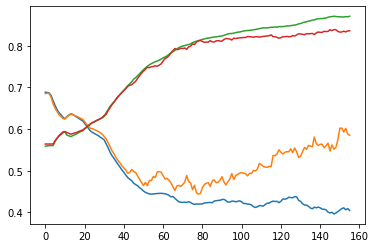

===============================  60s_f.pkl   =====   lstm60    ============================
Epoch:  1 | train loss: 0.6909 | train_accuracy: 0.53 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.689 | train loss t:0.6936
Epoch:  2 | train loss: 0.6883 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.686 | train loss t:0.6894
Epoch:  3 | train loss: 0.6805 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.668 | train loss t:0.6834
Epoch:  4 | train loss: 0.6441 | train_accuracy: 0.57 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.660 | train loss t:0.6571
Epoch:  5 | train loss: 0.6897 | train_accuracy: 0.57 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.688 | train loss t:0.6879
Epoch:  6 | train loss: 0.6856 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.683 | train loss t:0.6868
Epoch:  7 | train loss: 0.6456 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.617 | train loss t:0.6566
Epoch

Epoch:  59 | train loss: 0.3651 | train_accuracy: 0.81 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.425 | train loss t:0.3690
EarlyStopping counter: 4 out of 10,best_is:0.8025547445255474
Epoch:  60 | train loss: 0.3460 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.428 | train loss t:0.3514
Epoch:  61 | train loss: 0.3333 | train_accuracy: 0.83 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.405 | train loss t:0.3364
Epoch:  62 | train loss: 0.3335 | train_accuracy: 0.83 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.419 | train loss t:0.3356
Epoch:  63 | train loss: 0.3424 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.416 | train loss t:0.3476
EarlyStopping counter: 1 out of 10,best_is:0.8102189781021898
Epoch:  64 | train loss: 0.3451 | train_accuracy: 0.82 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.383 | train loss t:0.3443
Epoch:  65 | train loss: 0.3426 | train_accuracy: 0.82 | test accuracy: 0.82 | rl:0.00030 | loss

Epoch:  108 | train loss: 0.2729 | train_accuracy: 0.88 | test accuracy: 0.88 | rl:0.00030 | loss_test:0.285 | train loss t:0.2526
Epoch:  109 | train loss: 0.2695 | train_accuracy: 0.88 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.335 | train loss t:0.2411
EarlyStopping counter: 1 out of 10,best_is:0.8754020154373928
Epoch:  110 | train loss: 0.2820 | train_accuracy: 0.88 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.480 | train loss t:0.2263
EarlyStopping counter: 2 out of 10,best_is:0.8754020154373928
Epoch:  111 | train loss: 0.2814 | train_accuracy: 0.88 | test accuracy: 0.87 | rl:0.00030 | loss_test:0.318 | train loss t:0.2303
Epoch:  112 | train loss: 0.2722 | train_accuracy: 0.88 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.432 | train loss t:0.2339
EarlyStopping counter: 1 out of 10,best_is:0.8754020154373928
Epoch:  113 | train loss: 0.2550 | train_accuracy: 0.89 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.527 | train loss t:0.2303
EarlyStopping counter: 2 out

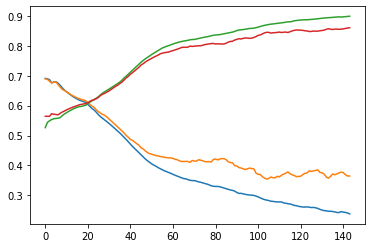

===============================  30s_f.pkl   =====   lstm30    ============================
Epoch:  1 | train loss: 0.6933 | train_accuracy: 0.50 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.688 | train loss t:0.6961
Epoch:  2 | train loss: 0.6873 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.689 | train loss t:0.6895
Epoch:  3 | train loss: 0.6796 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.664 | train loss t:0.6832
Epoch:  4 | train loss: 0.6560 | train_accuracy: 0.56 | test accuracy: 0.59 | rl:0.00030 | loss_test:0.656 | train loss t:0.6687
Epoch:  5 | train loss: 0.6426 | train_accuracy: 0.59 | test accuracy: 0.59 | rl:0.00030 | loss_test:0.640 | train loss t:0.6523
Epoch:  6 | train loss: 0.6372 | train_accuracy: 0.59 | test accuracy: 0.59 | rl:0.00030 | loss_test:0.632 | train loss t:0.6483
Epoch:  7 | train loss: 0.6144 | train_accuracy: 0.60 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.615 | train loss t:0.6246
Epoch

Epoch:  60 | train loss: 0.3569 | train_accuracy: 0.81 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.398 | train loss t:0.3630
EarlyStopping counter: 2 out of 10,best_is:0.8062043795620438
Epoch:  61 | train loss: 0.3515 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.394 | train loss t:0.3557
Epoch:  62 | train loss: 0.3575 | train_accuracy: 0.81 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.381 | train loss t:0.3434
Epoch:  63 | train loss: 0.3521 | train_accuracy: 0.82 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.369 | train loss t:0.3454
Epoch:  64 | train loss: 0.3605 | train_accuracy: 0.81 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.349 | train loss t:0.3409
Epoch:  65 | train loss: 0.3475 | train_accuracy: 0.82 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.373 | train loss t:0.3497
Epoch:  66 | train loss: 0.3604 | train_accuracy: 0.81 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.474 | train loss t:0.3359
EarlyStopping counter: 1 out

Epoch:  110 | train loss: 0.3276 | train_accuracy: 0.84 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.441 | train loss t:0.2753
EarlyStopping counter: 4 out of 10,best_is:0.8440950632504287
Epoch:  111 | train loss: 0.3331 | train_accuracy: 0.85 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.425 | train loss t:0.2627
EarlyStopping counter: 5 out of 10,best_is:0.8440950632504287
Epoch:  112 | train loss: 0.3217 | train_accuracy: 0.85 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.341 | train loss t:0.2728
Epoch:  113 | train loss: 0.3323 | train_accuracy: 0.84 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.586 | train loss t:0.2575
EarlyStopping counter: 1 out of 10,best_is:0.8440950632504287
Epoch:  114 | train loss: 0.3403 | train_accuracy: 0.84 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.457 | train loss t:0.2912
EarlyStopping counter: 2 out of 10,best_is:0.8440950632504287
Epoch:  115 | train loss: 0.3276 | train_accuracy: 0.85 | test accuracy: 0.85 | rl:0.00030 | loss

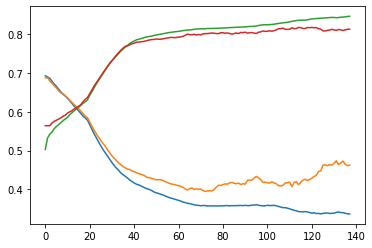

In [10]:
for i in shiyan_list[::-1]:
    wenjian,net_name,bs,time = i
    wj_name = "记录1"
    print("===============================  {}   =====   {}    ============================".format(wenjian,net_name))             
    xunlian(net_name = net_name,wenjian = wenjian,batch_tr = int(256),batch_te = 1000,
            lr = 0.0003, path_save="xunlian",epochs = 600,wj_name = wj_name,time = time)
    path1 =r'./{}/{}/{}/{}/logging.csv'.format(wj_name,wenjian[0],net_name[0],wenjian[-5])
    smooth(path1)

===============================  90s_f.pkl   =====   lstm90    ============================
Epoch:  1 | train loss: 0.6904 | train_accuracy: 0.54 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6929
Epoch:  2 | train loss: 0.6846 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.685 | train loss t:0.6863
Epoch:  3 | train loss: 0.6653 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.662 | train loss t:0.6717
Epoch:  4 | train loss: 0.6205 | train_accuracy: 0.59 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.640 | train loss t:0.6284
Epoch:  5 | train loss: 0.5981 | train_accuracy: 0.61 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.592 | train loss t:0.5973
Epoch:  6 | train loss: 0.5999 | train_accuracy: 0.61 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.586 | train loss t:0.5963
Epoch:  7 | train loss: 0.5937 | train_accuracy: 0.62 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.589 | train loss t:0.5907
Epoch

Epoch:  60 | train loss: 0.6353 | train_accuracy: 0.76 | test accuracy: 0.73 | rl:0.00030 | loss_test:0.718 | train loss t:0.3276
EarlyStopping counter: 1 out of 10,best_is:0.7654675439536878
Epoch:  61 | train loss: 0.6076 | train_accuracy: 0.75 | test accuracy: 0.71 | rl:0.00030 | loss_test:0.949 | train loss t:0.2978
EarlyStopping counter: 2 out of 10,best_is:0.7654675439536878
Epoch:  62 | train loss: 0.6270 | train_accuracy: 0.76 | test accuracy: 0.73 | rl:0.00030 | loss_test:0.648 | train loss t:0.3099
EarlyStopping counter: 3 out of 10,best_is:0.7654675439536878
Epoch:  63 | train loss: 0.5510 | train_accuracy: 0.77 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.554 | train loss t:0.2917
Epoch:  64 | train loss: 0.6176 | train_accuracy: 0.76 | test accuracy: 0.74 | rl:0.00030 | loss_test:0.675 | train loss t:0.3064
EarlyStopping counter: 1 out of 10,best_is:0.7715328467153285
Epoch:  65 | train loss: 0.6010 | train_accuracy: 0.77 | test accuracy: 0.70 | rl:0.00030 | loss_test:

Epoch:  108 | train loss: 0.5618 | train_accuracy: 0.81 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.771 | train loss t:0.1796
EarlyStopping counter: 2 out of 10,best_is:0.8091240875912409
Epoch:  109 | train loss: 0.6010 | train_accuracy: 0.81 | test accuracy: 0.75 | rl:0.00030 | loss_test:1.012 | train loss t:0.1707
EarlyStopping counter: 3 out of 10,best_is:0.8091240875912409
Epoch:  110 | train loss: 0.6386 | train_accuracy: 0.80 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.653 | train loss t:0.1884
EarlyStopping counter: 4 out of 10,best_is:0.8091240875912409
Epoch:  111 | train loss: 0.5768 | train_accuracy: 0.81 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.914 | train loss t:0.1882
EarlyStopping counter: 5 out of 10,best_is:0.8091240875912409
Epoch:  112 | train loss: 0.6676 | train_accuracy: 0.81 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.511 | train loss t:0.1760
Epoch:  113 | train loss: 0.5522 | train_accuracy: 0.81 | test accuracy: 0.75 | rl:0.00030 | loss

Epoch:  154 | train loss: 0.6648 | train_accuracy: 0.83 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.884 | train loss t:0.1262
EarlyStopping counter: 7 out of 10,best_is:0.8227413432675814
Epoch:  155 | train loss: 0.6441 | train_accuracy: 0.82 | test accuracy: 0.79 | rl:0.00030 | loss_test:1.089 | train loss t:0.1205
EarlyStopping counter: 8 out of 10,best_is:0.8227413432675814
Epoch:  156 | train loss: 0.6879 | train_accuracy: 0.83 | test accuracy: 0.76 | rl:0.00030 | loss_test:1.254 | train loss t:0.1265
EarlyStopping counter: 9 out of 10,best_is:0.8227413432675814
Epoch:  157 | train loss: 0.8727 | train_accuracy: 0.80 | test accuracy: 0.73 | rl:0.00030 | loss_test:1.139 | train loss t:0.1333
EarlyStopping counter: 10 out of 10,best_is:0.8227413432675814


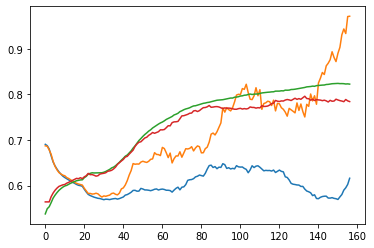

===============================  60s_f.pkl   =====   lstm60    ============================
Epoch:  1 | train loss: 0.6902 | train_accuracy: 0.53 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.686 | train loss t:0.6920
Epoch:  2 | train loss: 0.6859 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6905
Epoch:  3 | train loss: 0.6817 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.680 | train loss t:0.6855
Epoch:  4 | train loss: 0.6479 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.625 | train loss t:0.6620
Epoch:  5 | train loss: 0.6005 | train_accuracy: 0.62 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.590 | train loss t:0.6156
Epoch:  6 | train loss: 0.5836 | train_accuracy: 0.63 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.598 | train loss t:0.6076
Epoch:  7 | train loss: 0.5802 | train_accuracy: 0.63 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.593 | train loss t:0.5940
Epoch

Epoch:  57 | train loss: 0.3743 | train_accuracy: 0.82 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.351 | train loss t:0.3295
Epoch:  58 | train loss: 0.3713 | train_accuracy: 0.83 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.422 | train loss t:0.3054
EarlyStopping counter: 1 out of 10,best_is:0.8178300546740995
Epoch:  59 | train loss: 0.3738 | train_accuracy: 0.82 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.386 | train loss t:0.3080
Epoch:  60 | train loss: 0.3577 | train_accuracy: 0.83 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.394 | train loss t:0.2944
Epoch:  61 | train loss: 0.3676 | train_accuracy: 0.82 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.395 | train loss t:0.3080
Epoch:  62 | train loss: 0.3671 | train_accuracy: 0.83 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.413 | train loss t:0.2900
EarlyStopping counter: 1 out of 10,best_is:0.8216056496569468
Epoch:  63 | train loss: 0.3865 | train_accuracy: 0.82 | test accuracy: 0.82 | rl:0.00030 | loss

Epoch:  105 | train loss: 0.3602 | train_accuracy: 0.85 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.545 | train loss t:0.1942
EarlyStopping counter: 6 out of 10,best_is:0.8375912408759124
Epoch:  106 | train loss: 0.3974 | train_accuracy: 0.85 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.609 | train loss t:0.1928
EarlyStopping counter: 7 out of 10,best_is:0.8375912408759124
Epoch:  107 | train loss: 0.4315 | train_accuracy: 0.85 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.613 | train loss t:0.2024
EarlyStopping counter: 8 out of 10,best_is:0.8375912408759124
Epoch:  108 | train loss: 0.3497 | train_accuracy: 0.85 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.376 | train loss t:0.2022
Epoch:  109 | train loss: 0.3588 | train_accuracy: 0.86 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.448 | train loss t:0.1912
EarlyStopping counter: 1 out of 10,best_is:0.8495390222984563
Epoch:  110 | train loss: 0.3601 | train_accuracy: 0.84 | test accuracy: 0.79 | rl:0.00030 | loss

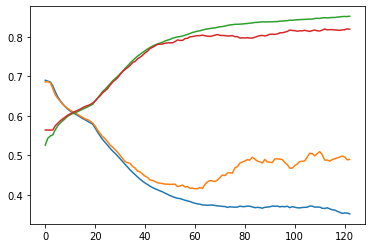

===============================  30s_f.pkl   =====   lstm30    ============================
Epoch:  1 | train loss: 0.6879 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6888
Epoch:  2 | train loss: 0.6866 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.685 | train loss t:0.6882
Epoch:  3 | train loss: 0.6743 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.666 | train loss t:0.6778
Epoch:  4 | train loss: 0.6665 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.655 | train loss t:0.6703
Epoch:  5 | train loss: 0.6426 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.637 | train loss t:0.6524
Epoch:  6 | train loss: 0.6238 | train_accuracy: 0.58 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.625 | train loss t:0.6392
Epoch:  7 | train loss: 0.6082 | train_accuracy: 0.60 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.629 | train loss t:0.6196
Epoch

Epoch:  58 | train loss: 0.3471 | train_accuracy: 0.82 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.376 | train loss t:0.3509
Epoch:  59 | train loss: 0.3495 | train_accuracy: 0.82 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.364 | train loss t:0.3475
Epoch:  60 | train loss: 0.3409 | train_accuracy: 0.82 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.441 | train loss t:0.3301
EarlyStopping counter: 1 out of 10,best_is:0.8220177154802745
Epoch:  61 | train loss: 0.3432 | train_accuracy: 0.83 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.367 | train loss t:0.3257
Epoch:  62 | train loss: 0.3515 | train_accuracy: 0.82 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.357 | train loss t:0.3337
Epoch:  63 | train loss: 0.3416 | train_accuracy: 0.83 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.406 | train loss t:0.3309
EarlyStopping counter: 1 out of 10,best_is:0.8231433587049742
Epoch:  64 | train loss: 0.3471 | train_accuracy: 0.83 | test accuracy: 0.78 | rl:0.00030 | loss

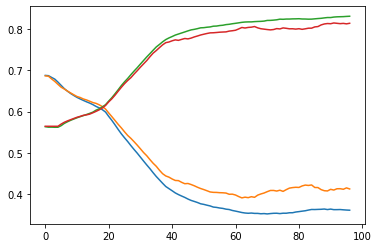

In [11]:
for i in shiyan_list[::-1]:
    wenjian,net_name,bs,time = i
    wj_name = "记录2"
    print("===============================  {}   =====   {}    ============================".format(wenjian,net_name))             
    xunlian(net_name = net_name,wenjian = wenjian,batch_tr = int(256),batch_te = 1000,
            lr = 0.0003, path_save="xunlian",epochs = 600,wj_name = wj_name,time = time)
    path1 =r'./{}/{}/{}/{}/logging.csv'.format(wj_name,wenjian[0],net_name[0],wenjian[-5])
    smooth(path1)

===============================  90s_f.pkl   =====   lstm90    ============================
Epoch:  1 | train loss: 0.6883 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6904
Epoch:  2 | train loss: 0.6878 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6887
Epoch:  3 | train loss: 0.6848 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.684 | train loss t:0.6856
Epoch:  4 | train loss: 0.6671 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.644 | train loss t:0.6732
Epoch:  5 | train loss: 0.6307 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.611 | train loss t:0.6460
Epoch:  6 | train loss: 0.5877 | train_accuracy: 0.61 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.587 | train loss t:0.6061
Epoch:  7 | train loss: 0.5985 | train_accuracy: 0.61 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.593 | train loss t:0.6178
Epoch

Epoch:  59 | train loss: 0.3559 | train_accuracy: 0.82 | test accuracy: 0.86 | rl:0.00030 | loss_test:0.313 | train loss t:0.2939
Epoch:  60 | train loss: 0.3816 | train_accuracy: 0.81 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.338 | train loss t:0.3021
Epoch:  61 | train loss: 0.3770 | train_accuracy: 0.82 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.362 | train loss t:0.2844
EarlyStopping counter: 1 out of 10,best_is:0.8241349967838765
Epoch:  62 | train loss: 0.3675 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.383 | train loss t:0.2831
EarlyStopping counter: 2 out of 10,best_is:0.8241349967838765
Epoch:  63 | train loss: 0.3812 | train_accuracy: 0.81 | test accuracy: 0.72 | rl:0.00030 | loss_test:0.591 | train loss t:0.2668
EarlyStopping counter: 3 out of 10,best_is:0.8241349967838765
Epoch:  64 | train loss: 0.3673 | train_accuracy: 0.82 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.399 | train loss t:0.2770
EarlyStopping counter: 4 out of 10

Epoch:  108 | train loss: 0.3086 | train_accuracy: 0.86 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.419 | train loss t:0.1917
EarlyStopping counter: 4 out of 10,best_is:0.8734354899228131
Epoch:  109 | train loss: 0.3051 | train_accuracy: 0.87 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.500 | train loss t:0.1654
EarlyStopping counter: 5 out of 10,best_is:0.8734354899228131
Epoch:  110 | train loss: 0.3262 | train_accuracy: 0.87 | test accuracy: 0.86 | rl:0.00030 | loss_test:0.379 | train loss t:0.1749
EarlyStopping counter: 6 out of 10,best_is:0.8734354899228131
Epoch:  111 | train loss: 0.3255 | train_accuracy: 0.87 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.710 | train loss t:0.1759
EarlyStopping counter: 7 out of 10,best_is:0.8734354899228131
Epoch:  112 | train loss: 0.2991 | train_accuracy: 0.87 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.566 | train loss t:0.1859
EarlyStopping counter: 8 out of 10,best_is:0.8734354899228131
Epoch:  113 | train loss: 0.3027 | 

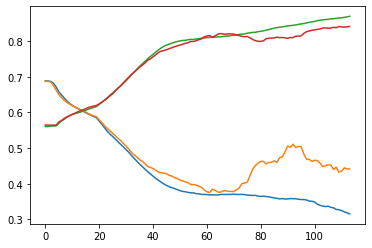

===============================  60s_f.pkl   =====   lstm60    ============================
Epoch:  1 | train loss: 0.6897 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.688 | train loss t:0.6908
Epoch:  2 | train loss: 0.6862 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6890
Epoch:  3 | train loss: 0.6833 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.681 | train loss t:0.6871
Epoch:  4 | train loss: 0.6485 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.621 | train loss t:0.6635
Epoch:  5 | train loss: 0.6108 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.607 | train loss t:0.6336
Epoch:  6 | train loss: 0.5881 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.593 | train loss t:0.6052
Epoch:  7 | train loss: 0.5941 | train_accuracy: 0.62 | test accuracy: 0.63 | rl:0.00030 | loss_test:0.599 | train loss t:0.6084
Epoch

Epoch:  57 | train loss: 0.4352 | train_accuracy: 0.77 | test accuracy: 0.74 | rl:0.00030 | loss_test:0.557 | train loss t:0.3467
EarlyStopping counter: 1 out of 10,best_is:0.7787541541595197
Epoch:  58 | train loss: 0.4309 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.464 | train loss t:0.3394
Epoch:  59 | train loss: 0.4365 | train_accuracy: 0.77 | test accuracy: 0.70 | rl:0.00030 | loss_test:0.541 | train loss t:0.3555
EarlyStopping counter: 1 out of 10,best_is:0.7787541541595197
Epoch:  60 | train loss: 0.4208 | train_accuracy: 0.78 | test accuracy: 0.75 | rl:0.00030 | loss_test:0.481 | train loss t:0.3551
EarlyStopping counter: 2 out of 10,best_is:0.7787541541595197
Epoch:  61 | train loss: 0.4428 | train_accuracy: 0.77 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.499 | train loss t:0.3640
EarlyStopping counter: 3 out of 10,best_is:0.7787541541595197
Epoch:  62 | train loss: 0.4333 | train_accuracy: 0.78 | test accuracy: 0.78 | rl:0.00030 | loss_test:

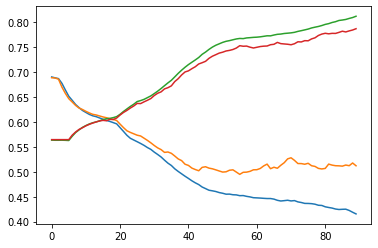

===============================  30s_f.pkl   =====   lstm30    ============================
Epoch:  1 | train loss: 0.6877 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6886
Epoch:  2 | train loss: 0.6868 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.685 | train loss t:0.6871
Epoch:  3 | train loss: 0.6725 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.656 | train loss t:0.6740
Epoch:  4 | train loss: 0.6424 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.651 | train loss t:0.6521
Epoch:  5 | train loss: 0.6341 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.632 | train loss t:0.6430
Epoch:  6 | train loss: 0.6239 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.628 | train loss t:0.6354
Epoch:  7 | train loss: 0.6179 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.622 | train loss t:0.6307
Epoch

Epoch:  58 | train loss: 0.3765 | train_accuracy: 0.80 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.407 | train loss t:0.3743
Epoch:  59 | train loss: 0.3730 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.429 | train loss t:0.3710
EarlyStopping counter: 1 out of 10,best_is:0.7935650728987992
Epoch:  60 | train loss: 0.3818 | train_accuracy: 0.79 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.399 | train loss t:0.3583
Epoch:  61 | train loss: 0.3857 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.410 | train loss t:0.3727
EarlyStopping counter: 1 out of 10,best_is:0.7935650728987992
Epoch:  62 | train loss: 0.3731 | train_accuracy: 0.79 | test accuracy: 0.75 | rl:0.00030 | loss_test:0.439 | train loss t:0.3637
EarlyStopping counter: 2 out of 10,best_is:0.7935650728987992
Epoch:  63 | train loss: 0.3722 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.415 | train loss t:0.3578
EarlyStopping counter: 3 out of 10

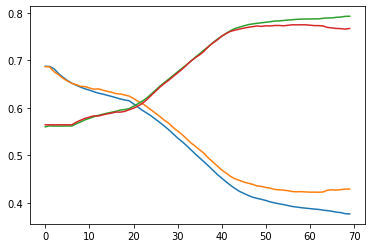

In [12]:
for i in shiyan_list[::-1]:
    wenjian,net_name,bs,time = i
    wj_name = "记录3"
    print("===============================  {}   =====   {}    ============================".format(wenjian,net_name))             
    xunlian(net_name = net_name,wenjian = wenjian,batch_tr = int(256),batch_te = 1000,
            lr = 0.0003, path_save="xunlian",epochs = 600,wj_name = wj_name,time = time)
    path1 =r'./{}/{}/{}/{}/logging.csv'.format(wj_name,wenjian[0],net_name[0],wenjian[-5])
    smooth(path1)

===============================  90s_f.pkl   =====   lstm90    ============================
Epoch:  1 | train loss: 0.6893 | train_accuracy: 0.54 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6919
Epoch:  2 | train loss: 0.6837 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.677 | train loss t:0.6867
Epoch:  3 | train loss: 0.6702 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.680 | train loss t:0.6772
Epoch:  4 | train loss: 0.6494 | train_accuracy: 0.57 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.627 | train loss t:0.6537
Epoch:  5 | train loss: 0.6157 | train_accuracy: 0.61 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.607 | train loss t:0.6131
Epoch:  6 | train loss: 0.6048 | train_accuracy: 0.61 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.602 | train loss t:0.5948
Epoch:  7 | train loss: 0.6179 | train_accuracy: 0.60 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.588 | train loss t:0.6117
Epoch

Epoch:  59 | train loss: 0.6098 | train_accuracy: 0.76 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.793 | train loss t:0.2538
Epoch:  60 | train loss: 0.6197 | train_accuracy: 0.77 | test accuracy: 0.70 | rl:0.00030 | loss_test:0.904 | train loss t:0.2399
EarlyStopping counter: 1 out of 10,best_is:0.762043795620438
Epoch:  61 | train loss: 0.6312 | train_accuracy: 0.76 | test accuracy: 0.73 | rl:0.00030 | loss_test:0.874 | train loss t:0.2322
EarlyStopping counter: 2 out of 10,best_is:0.762043795620438
Epoch:  62 | train loss: 0.6322 | train_accuracy: 0.78 | test accuracy: 0.72 | rl:0.00030 | loss_test:0.815 | train loss t:0.2272
EarlyStopping counter: 3 out of 10,best_is:0.762043795620438
Epoch:  63 | train loss: 0.6456 | train_accuracy: 0.78 | test accuracy: 0.74 | rl:0.00030 | loss_test:0.835 | train loss t:0.2310
EarlyStopping counter: 4 out of 10,best_is:0.762043795620438
Epoch:  64 | train loss: 0.6190 | train_accuracy: 0.78 | test accuracy: 0.71 | rl:0.00030 | loss_test:0.92

Epoch:  106 | train loss: 0.5603 | train_accuracy: 0.83 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.691 | train loss t:0.1298
EarlyStopping counter: 1 out of 10,best_is:0.8154045615351628
Epoch:  107 | train loss: 0.6711 | train_accuracy: 0.82 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.646 | train loss t:0.1244
Epoch:  108 | train loss: 0.5592 | train_accuracy: 0.82 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.525 | train loss t:0.1246
Epoch:  109 | train loss: 0.6279 | train_accuracy: 0.82 | test accuracy: 0.75 | rl:0.00030 | loss_test:1.073 | train loss t:0.1269
EarlyStopping counter: 1 out of 10,best_is:0.8227446933962264
Epoch:  110 | train loss: 0.7804 | train_accuracy: 0.80 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.605 | train loss t:0.1235
Epoch:  111 | train loss: 0.7192 | train_accuracy: 0.81 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.586 | train loss t:0.1286
Epoch:  112 | train loss: 0.5511 | train_accuracy: 0.82 | test accuracy: 0.79 | rl:0.00030

Epoch:  153 | train loss: 0.5432 | train_accuracy: 0.86 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.866 | train loss t:0.0787
EarlyStopping counter: 8 out of 10,best_is:0.8456763239708405
Epoch:  154 | train loss: 0.5897 | train_accuracy: 0.86 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.776 | train loss t:0.0942
EarlyStopping counter: 9 out of 10,best_is:0.8456763239708405
Epoch:  155 | train loss: 0.5067 | train_accuracy: 0.86 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.778 | train loss t:0.0780
EarlyStopping counter: 10 out of 10,best_is:0.8456763239708405


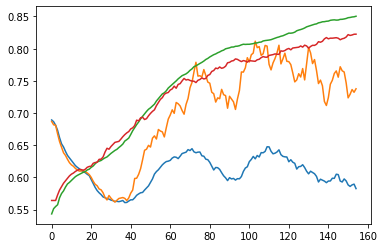

===============================  60s_f.pkl   =====   lstm60    ============================
Epoch:  1 | train loss: 0.6909 | train_accuracy: 0.53 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.689 | train loss t:0.6937
Epoch:  2 | train loss: 0.6860 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6897
Epoch:  3 | train loss: 0.6713 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.659 | train loss t:0.6779
Epoch:  4 | train loss: 0.6309 | train_accuracy: 0.58 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.673 | train loss t:0.6454
Epoch:  5 | train loss: 0.6224 | train_accuracy: 0.60 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.605 | train loss t:0.6406
Epoch:  6 | train loss: 0.5925 | train_accuracy: 0.61 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.602 | train loss t:0.6067
Epoch:  7 | train loss: 0.5862 | train_accuracy: 0.62 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.589 | train loss t:0.5962
Epoch

Epoch:  60 | train loss: 0.4616 | train_accuracy: 0.75 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.484 | train loss t:0.3457
EarlyStopping counter: 1 out of 10,best_is:0.7702917292024014
Epoch:  61 | train loss: 0.4811 | train_accuracy: 0.76 | test accuracy: 0.68 | rl:0.00030 | loss_test:0.612 | train loss t:0.3374
EarlyStopping counter: 2 out of 10,best_is:0.7702917292024014
Epoch:  62 | train loss: 0.4383 | train_accuracy: 0.77 | test accuracy: 0.72 | rl:0.00030 | loss_test:0.561 | train loss t:0.3374
EarlyStopping counter: 3 out of 10,best_is:0.7702917292024014
Epoch:  63 | train loss: 0.4523 | train_accuracy: 0.78 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.472 | train loss t:0.3268
Epoch:  64 | train loss: 0.4541 | train_accuracy: 0.79 | test accuracy: 0.75 | rl:0.00030 | loss_test:0.601 | train loss t:0.3316
EarlyStopping counter: 1 out of 10,best_is:0.7702917292024014
Epoch:  65 | train loss: 0.4360 | train_accuracy: 0.78 | test accuracy: 0.80 | rl:0.00030 | loss_test:

Epoch:  108 | train loss: 0.4447 | train_accuracy: 0.82 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.756 | train loss t:0.2297
EarlyStopping counter: 6 out of 10,best_is:0.8274616745283019
Epoch:  109 | train loss: 0.4122 | train_accuracy: 0.83 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.552 | train loss t:0.2237
EarlyStopping counter: 7 out of 10,best_is:0.8274616745283019
Epoch:  110 | train loss: 0.4283 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.568 | train loss t:0.2190
EarlyStopping counter: 8 out of 10,best_is:0.8274616745283019
Epoch:  111 | train loss: 0.4756 | train_accuracy: 0.81 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.624 | train loss t:0.2203
EarlyStopping counter: 9 out of 10,best_is:0.8274616745283019
Epoch:  112 | train loss: 0.3839 | train_accuracy: 0.84 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.498 | train loss t:0.2202
Epoch:  113 | train loss: 0.4509 | train_accuracy: 0.83 | test accuracy: 0.86 | rl:0.00030 | loss

Epoch:  156 | train loss: 0.4347 | train_accuracy: 0.84 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.725 | train loss t:0.1729
EarlyStopping counter: 6 out of 10,best_is:0.8531337103344768
Epoch:  157 | train loss: 0.3518 | train_accuracy: 0.86 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.603 | train loss t:0.1576
EarlyStopping counter: 7 out of 10,best_is:0.8531337103344768
Epoch:  158 | train loss: 0.3610 | train_accuracy: 0.86 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.498 | train loss t:0.1650
Epoch:  159 | train loss: 0.3712 | train_accuracy: 0.87 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.751 | train loss t:0.1472
EarlyStopping counter: 1 out of 10,best_is:0.8543795620437956
Epoch:  160 | train loss: 0.4097 | train_accuracy: 0.86 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.854 | train loss t:0.1421
EarlyStopping counter: 2 out of 10,best_is:0.8543795620437956
Epoch:  161 | train loss: 0.4419 | train_accuracy: 0.85 | test accuracy: 0.79 | rl:0.00030 | loss

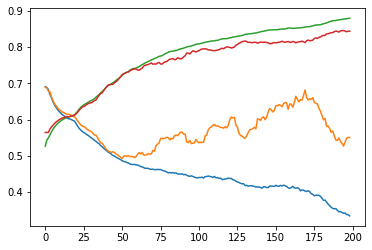

===============================  30s_f.pkl   =====   lstm30    ============================
Epoch:  1 | train loss: 0.6890 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6903
Epoch:  2 | train loss: 0.6869 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.686 | train loss t:0.6882
Epoch:  3 | train loss: 0.6812 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.680 | train loss t:0.6836
Epoch:  4 | train loss: 0.6572 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.662 | train loss t:0.6631
Epoch:  5 | train loss: 0.6350 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.628 | train loss t:0.6469
Epoch:  6 | train loss: 0.6184 | train_accuracy: 0.57 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.617 | train loss t:0.6314
Epoch:  7 | train loss: 0.6066 | train_accuracy: 0.61 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.613 | train loss t:0.6180
Epoch

Epoch:  55 | train loss: 0.4317 | train_accuracy: 0.75 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.428 | train loss t:0.3794
Epoch:  56 | train loss: 0.4291 | train_accuracy: 0.76 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.433 | train loss t:0.3851
Epoch:  57 | train loss: 0.4300 | train_accuracy: 0.76 | test accuracy: 0.73 | rl:0.00030 | loss_test:0.501 | train loss t:0.3949
EarlyStopping counter: 1 out of 10,best_is:0.7655278462692968
Epoch:  58 | train loss: 0.4240 | train_accuracy: 0.76 | test accuracy: 0.74 | rl:0.00030 | loss_test:0.472 | train loss t:0.3981
EarlyStopping counter: 2 out of 10,best_is:0.7655278462692968
Epoch:  59 | train loss: 0.4189 | train_accuracy: 0.77 | test accuracy: 0.72 | rl:0.00030 | loss_test:0.510 | train loss t:0.3610
EarlyStopping counter: 3 out of 10,best_is:0.7655278462692968
Epoch:  60 | train loss: 0.4210 | train_accuracy: 0.77 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.428 | train loss t:0.3622
Epoch:  61 | train loss: 0.4296 | 

Epoch:  104 | train loss: 0.4509 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.527 | train loss t:0.2900
EarlyStopping counter: 3 out of 10,best_is:0.7952554744525547
Epoch:  105 | train loss: 0.4444 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.483 | train loss t:0.2916
EarlyStopping counter: 4 out of 10,best_is:0.7952554744525547
Epoch:  106 | train loss: 0.4633 | train_accuracy: 0.79 | test accuracy: 0.77 | rl:0.00030 | loss_test:0.562 | train loss t:0.2703
EarlyStopping counter: 5 out of 10,best_is:0.7952554744525547
Epoch:  107 | train loss: 0.4904 | train_accuracy: 0.79 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.434 | train loss t:0.2827
Epoch:  108 | train loss: 0.4329 | train_accuracy: 0.79 | test accuracy: 0.74 | rl:0.00030 | loss_test:0.635 | train loss t:0.2870
EarlyStopping counter: 1 out of 10,best_is:0.7952554744525547
Epoch:  109 | train loss: 0.4247 | train_accuracy: 0.80 | test accuracy: 0.80 | rl:0.00030 | loss

Epoch:  151 | train loss: 0.4059 | train_accuracy: 0.83 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.527 | train loss t:0.2396
EarlyStopping counter: 5 out of 10,best_is:0.8182481751824817
Epoch:  152 | train loss: 0.3839 | train_accuracy: 0.84 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.558 | train loss t:0.2293
EarlyStopping counter: 6 out of 10,best_is:0.8182481751824817
Epoch:  153 | train loss: 0.4258 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.518 | train loss t:0.2262
EarlyStopping counter: 7 out of 10,best_is:0.8182481751824817
Epoch:  154 | train loss: 0.4126 | train_accuracy: 0.82 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.553 | train loss t:0.2348
EarlyStopping counter: 8 out of 10,best_is:0.8182481751824817
Epoch:  155 | train loss: 0.3903 | train_accuracy: 0.82 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.527 | train loss t:0.2726
EarlyStopping counter: 9 out of 10,best_is:0.8182481751824817
Epoch:  156 | train loss: 0.3761 | 

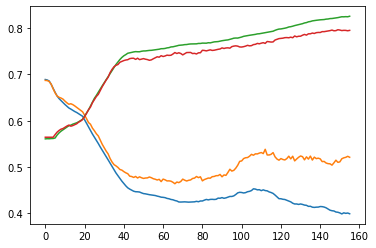

In [13]:
for i in shiyan_list[::-1]:
    wenjian,net_name,bs,time = i
    wj_name = "记录4"
    print("===============================  {}   =====   {}    ============================".format(wenjian,net_name))             
    xunlian(net_name = net_name,wenjian = wenjian,batch_tr = int(256),batch_te = 1000,
            lr = 0.0003, path_save="xunlian",epochs = 600,wj_name = wj_name,time = time)
    path1 =r'./{}/{}/{}/{}/logging.csv'.format(wj_name,wenjian[0],net_name[0],wenjian[-5])
    smooth(path1)

===============================  90s_f.pkl   =====   lstm90    ============================
Epoch:  1 | train loss: 0.6882 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.686 | train loss t:0.6883
Epoch:  2 | train loss: 0.6872 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.687 | train loss t:0.6878
Epoch:  3 | train loss: 0.6820 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.672 | train loss t:0.6824
Epoch:  4 | train loss: 0.6645 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.645 | train loss t:0.6688
Epoch:  5 | train loss: 0.6137 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.595 | train loss t:0.6251
Epoch:  6 | train loss: 0.5848 | train_accuracy: 0.58 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.612 | train loss t:0.5979
Epoch:  7 | train loss: 0.5754 | train_accuracy: 0.63 | test accuracy: 0.63 | rl:0.00030 | loss_test:0.582 | train loss t:0.5839
Epoch

Epoch:  56 | train loss: 0.4539 | train_accuracy: 0.78 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.532 | train loss t:0.2939
EarlyStopping counter: 2 out of 10,best_is:0.7770824399656946
Epoch:  57 | train loss: 0.5377 | train_accuracy: 0.76 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.488 | train loss t:0.2727
EarlyStopping counter: 3 out of 10,best_is:0.7770824399656946
Epoch:  58 | train loss: 0.4876 | train_accuracy: 0.77 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.490 | train loss t:0.2840
EarlyStopping counter: 4 out of 10,best_is:0.7770824399656946
Epoch:  59 | train loss: 0.4743 | train_accuracy: 0.78 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.422 | train loss t:0.2611
Epoch:  60 | train loss: 0.5388 | train_accuracy: 0.78 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.360 | train loss t:0.2461
Epoch:  61 | train loss: 0.5395 | train_accuracy: 0.78 | test accuracy: 0.75 | rl:0.00030 | loss_test:0.492 | train loss t:0.2874
EarlyStopping counter: 1 out of 10

Epoch:  107 | train loss: 0.5179 | train_accuracy: 0.84 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.566 | train loss t:0.1703
EarlyStopping counter: 3 out of 10,best_is:0.8453815126500858
Epoch:  108 | train loss: 0.5095 | train_accuracy: 0.84 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.769 | train loss t:0.1650
EarlyStopping counter: 4 out of 10,best_is:0.8453815126500858
Epoch:  109 | train loss: 0.5362 | train_accuracy: 0.83 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.461 | train loss t:0.2088
EarlyStopping counter: 5 out of 10,best_is:0.8453815126500858
Epoch:  110 | train loss: 0.4619 | train_accuracy: 0.84 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.427 | train loss t:0.1702
Epoch:  111 | train loss: 0.4575 | train_accuracy: 0.86 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.659 | train loss t:0.1592
Epoch:  112 | train loss: 0.5547 | train_accuracy: 0.84 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.640 | train loss t:0.1481
Epoch:  113 | train loss: 0.

Epoch:  153 | train loss: 0.4276 | train_accuracy: 0.88 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.614 | train loss t:0.1224
EarlyStopping counter: 1 out of 10,best_is:0.8697080291970803
Epoch:  154 | train loss: 0.3649 | train_accuracy: 0.90 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.698 | train loss t:0.0949
EarlyStopping counter: 2 out of 10,best_is:0.8697080291970803
Epoch:  155 | train loss: 0.3830 | train_accuracy: 0.90 | test accuracy: 0.85 | rl:0.00030 | loss_test:0.493 | train loss t:0.1003
EarlyStopping counter: 3 out of 10,best_is:0.8697080291970803
Epoch:  156 | train loss: 0.3995 | train_accuracy: 0.88 | test accuracy: 0.87 | rl:0.00030 | loss_test:0.417 | train loss t:0.1036
Epoch:  157 | train loss: 0.4706 | train_accuracy: 0.88 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.551 | train loss t:0.1011
EarlyStopping counter: 1 out of 10,best_is:0.8697080291970803
Epoch:  158 | train loss: 0.3607 | train_accuracy: 0.90 | test accuracy: 0.84 | rl:0.00030 | loss

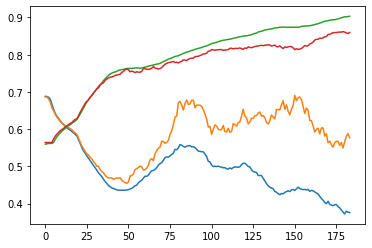

===============================  60s_f.pkl   =====   lstm60    ============================
Epoch:  1 | train loss: 0.6906 | train_accuracy: 0.53 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.688 | train loss t:0.6926
Epoch:  2 | train loss: 0.6842 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.678 | train loss t:0.6852
Epoch:  3 | train loss: 0.6653 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.647 | train loss t:0.6717
Epoch:  4 | train loss: 0.6233 | train_accuracy: 0.58 | test accuracy: 0.60 | rl:0.00030 | loss_test:0.620 | train loss t:0.6406
Epoch:  5 | train loss: 0.6114 | train_accuracy: 0.61 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.611 | train loss t:0.6280
Epoch:  6 | train loss: 0.5897 | train_accuracy: 0.62 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.601 | train loss t:0.6032
Epoch:  7 | train loss: 0.5823 | train_accuracy: 0.62 | test accuracy: 0.62 | rl:0.00030 | loss_test:0.584 | train loss t:0.5950
Epoch

Epoch:  58 | train loss: 0.4165 | train_accuracy: 0.79 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.519 | train loss t:0.3508
EarlyStopping counter: 1 out of 10,best_is:0.8064999195969126
Epoch:  59 | train loss: 0.4061 | train_accuracy: 0.80 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.449 | train loss t:0.3222
EarlyStopping counter: 2 out of 10,best_is:0.8064999195969126
Epoch:  60 | train loss: 0.4206 | train_accuracy: 0.80 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.552 | train loss t:0.3206
EarlyStopping counter: 3 out of 10,best_is:0.8064999195969126
Epoch:  61 | train loss: 0.4180 | train_accuracy: 0.79 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.471 | train loss t:0.3201
EarlyStopping counter: 4 out of 10,best_is:0.8064999195969126
Epoch:  62 | train loss: 0.4266 | train_accuracy: 0.81 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.493 | train loss t:0.3024
EarlyStopping counter: 5 out of 10,best_is:0.8064999195969126
Epoch:  63 | train loss: 0.4270 | train_

Epoch:  106 | train loss: 0.3223 | train_accuracy: 0.86 | test accuracy: 0.84 | rl:0.00030 | loss_test:0.415 | train loss t:0.2025
EarlyStopping counter: 7 out of 10,best_is:0.8557099592624356
Epoch:  107 | train loss: 0.3757 | train_accuracy: 0.86 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.618 | train loss t:0.2124
EarlyStopping counter: 8 out of 10,best_is:0.8557099592624356
Epoch:  108 | train loss: 0.3690 | train_accuracy: 0.85 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.495 | train loss t:0.2359
EarlyStopping counter: 9 out of 10,best_is:0.8557099592624356
Epoch:  109 | train loss: 0.3353 | train_accuracy: 0.87 | test accuracy: 0.83 | rl:0.00030 | loss_test:0.545 | train loss t:0.1902
EarlyStopping counter: 10 out of 10,best_is:0.8557099592624356


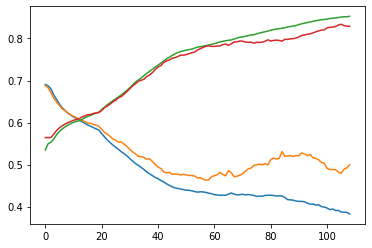

===============================  30s_f.pkl   =====   lstm30    ============================
Epoch:  1 | train loss: 0.6874 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.686 | train loss t:0.6886
Epoch:  2 | train loss: 0.6855 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.684 | train loss t:0.6874
Epoch:  3 | train loss: 0.6748 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.685 | train loss t:0.6792
Epoch:  4 | train loss: 0.6589 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.649 | train loss t:0.6668
Epoch:  5 | train loss: 0.6422 | train_accuracy: 0.56 | test accuracy: 0.56 | rl:0.00030 | loss_test:0.638 | train loss t:0.6553
Epoch:  6 | train loss: 0.6200 | train_accuracy: 0.58 | test accuracy: 0.61 | rl:0.00030 | loss_test:0.634 | train loss t:0.6324
Epoch:  7 | train loss: 0.6272 | train_accuracy: 0.60 | test accuracy: 0.59 | rl:0.00030 | loss_test:0.627 | train loss t:0.6363
Epoch

Epoch:  58 | train loss: 0.5154 | train_accuracy: 0.78 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.482 | train loss t:0.3330
Epoch:  59 | train loss: 0.5224 | train_accuracy: 0.76 | test accuracy: 0.72 | rl:0.00030 | loss_test:0.721 | train loss t:0.3543
EarlyStopping counter: 1 out of 10,best_is:0.7940977433533447
Epoch:  60 | train loss: 0.4859 | train_accuracy: 0.78 | test accuracy: 0.82 | rl:0.00030 | loss_test:0.433 | train loss t:0.3403
Epoch:  61 | train loss: 0.5125 | train_accuracy: 0.77 | test accuracy: 0.75 | rl:0.00030 | loss_test:0.589 | train loss t:0.3248
EarlyStopping counter: 1 out of 10,best_is:0.7940977433533447
Epoch:  62 | train loss: 0.4931 | train_accuracy: 0.78 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.562 | train loss t:0.3213
EarlyStopping counter: 2 out of 10,best_is:0.7940977433533447
Epoch:  63 | train loss: 0.5250 | train_accuracy: 0.77 | test accuracy: 0.76 | rl:0.00030 | loss_test:0.580 | train loss t:0.3251
EarlyStopping counter: 3 out of 10

Epoch:  107 | train loss: 0.5325 | train_accuracy: 0.80 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.514 | train loss t:0.2681
Epoch:  108 | train loss: 0.5325 | train_accuracy: 0.80 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.614 | train loss t:0.2528
EarlyStopping counter: 1 out of 10,best_is:0.8088048081046313
Epoch:  109 | train loss: 0.5636 | train_accuracy: 0.80 | test accuracy: 0.74 | rl:0.00030 | loss_test:0.792 | train loss t:0.2685
EarlyStopping counter: 2 out of 10,best_is:0.8088048081046313
Epoch:  110 | train loss: 0.5437 | train_accuracy: 0.80 | test accuracy: 0.81 | rl:0.00030 | loss_test:0.500 | train loss t:0.2675
Epoch:  111 | train loss: 0.5991 | train_accuracy: 0.79 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.603 | train loss t:0.2588
EarlyStopping counter: 1 out of 10,best_is:0.8088048081046313
Epoch:  112 | train loss: 0.5231 | train_accuracy: 0.80 | test accuracy: 0.78 | rl:0.00030 | loss_test:0.674 | train loss t:0.2571
EarlyStopping counter: 2 out

Epoch:  155 | train loss: 0.5028 | train_accuracy: 0.82 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.587 | train loss t:0.2280
EarlyStopping counter: 7 out of 10,best_is:0.8290462853773586
Epoch:  156 | train loss: 0.5255 | train_accuracy: 0.82 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.738 | train loss t:0.2220
EarlyStopping counter: 8 out of 10,best_is:0.8290462853773586
Epoch:  157 | train loss: 0.5032 | train_accuracy: 0.82 | test accuracy: 0.80 | rl:0.00030 | loss_test:0.707 | train loss t:0.2244
EarlyStopping counter: 9 out of 10,best_is:0.8290462853773586
Epoch:  158 | train loss: 0.5367 | train_accuracy: 0.82 | test accuracy: 0.79 | rl:0.00030 | loss_test:0.661 | train loss t:0.2197
EarlyStopping counter: 10 out of 10,best_is:0.8290462853773586


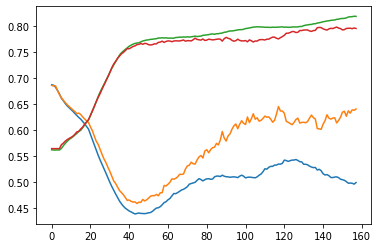

In [14]:
for i in shiyan_list[::-1]:
    wenjian,net_name,bs,time = i
    wj_name = "记录5"
    print("===============================  {}   =====   {}    ============================".format(wenjian,net_name))             
    xunlian(net_name = net_name,wenjian = wenjian,batch_tr = int(256),batch_te = 1000,
            lr = 0.0003, path_save="xunlian",epochs = 600,wj_name = wj_name,time = time)
    path1 =r'./{}/{}/{}/{}/logging.csv'.format(wj_name,wenjian[0],net_name[0],wenjian[-5])
    smooth(path1)